In [ ]:
#With OrganSMNIST and PathMNIST (Auxiliary)

Dataset 1 labels: [ 0  1  2  3  4  5  6  7  8  9 10]
Dataset 1 shape: (13932, 28, 28, 3)
Dataset 2 labels: [11 12 13 14 15 16 17 18 19]
Dataset 2 shape: (89996, 28, 28, 3)

Combined dataset:
Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Shape: (103928, 28, 28, 3)
Dataset 1 labels: [ 0  1  2  3  4  5  6  7  8  9 10]
Dataset 1 shape: (8827, 28, 28, 3)
Dataset 2 labels: [11 12 13 14 15 16 17 18 19]
Dataset 2 shape: (7180, 28, 28, 3)

Combined dataset:
Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Shape: (16007, 28, 28, 3)


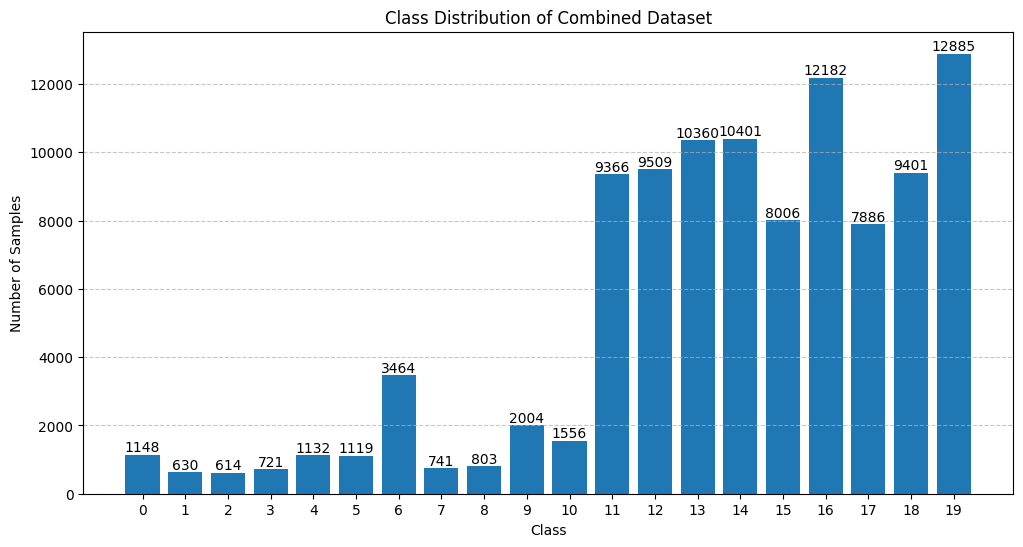

Number of samples in train dataset: 103928
Number of labels in train dataset: 20
Number of samples in test dataset: 16007
Number of labels in test dataset: 20


100%|█████████████████████████████████████████| 812/812 [01:24<00:00,  9.65it/s]


==> Evaluating ...
train Accuracy: 0.9835

Classification Report for train:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1148
           1       0.94      0.80      0.86       630
           2       0.84      0.92      0.88       614
           3       0.99      1.00      1.00       721
           4       0.99      1.00      0.99      1132
           5       0.99      0.98      0.99      1119
           6       1.00      1.00      1.00      3464
           7       1.00      0.99      1.00       741
           8       0.99      1.00      1.00       803
           9       0.98      1.00      0.99      2004
          10       1.00      0.99      0.99      1556
          11       1.00      1.00      1.00      9366
          12       1.00      1.00      1.00      9509
          13       0.92      1.00      0.96     10360
          14       1.00      1.00      1.00     10401
          15       0.99      1.00      1.00      8006
     

In [16]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Define the combine_datasets function
def combine_datasets(*datasets):
    combined_images = []
    combined_labels = []
    label_offset = 0

    for i, (images, labels) in enumerate(datasets):
        # If images are grayscale, convert them to RGB by repeating the channel
        if images.ndim == 3:
            images = np.expand_dims(images, axis=-1)
            images = np.repeat(images, 3, axis=-1)
        combined_images.append(images)
        
        # Adjust labels for uniqueness
        adjusted_labels = labels + label_offset
        combined_labels.append(adjusted_labels)
        
        # Update label offset for the next dataset
        label_offset += len(np.unique(labels))
        
        # Print information about this dataset
        print(f'Dataset {i+1} labels:', np.unique(adjusted_labels))
        print(f'Dataset {i+1} shape:', images.shape)

    # Combine all images and labels
    combined_images = np.concatenate(combined_images, axis=0)
    combined_labels = np.concatenate(combined_labels, axis=0)

    print('\nCombined dataset:')
    print('Labels:', np.unique(combined_labels))
    print('Shape:', combined_images.shape)

    return combined_images, combined_labels

# Load your datasets
organsmnist = np.load('/Users/srirammandalika/Downloads/MedMNIST/organsmnist.npz')
pathmnist = np.load('/Users/srirammandalika/Downloads/MedMNIST/pathmnist.npz')

# Extract images and labels
organsmnist_data = (organsmnist['train_images'], organsmnist['train_labels'])
pathmnist_data = (pathmnist['train_images'], pathmnist['train_labels'])

# Combine datasets
combined_images, combined_labels = combine_datasets(organsmnist_data, pathmnist_data)

# Combine test datasets
test_combined_images, test_combined_labels = combine_datasets((organsmnist['test_images'], organsmnist['test_labels']), (pathmnist['test_images'], pathmnist['test_labels']))

def plot_class_distribution(labels, title="Class Distribution"):
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(unique_labels, counts)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')
    
    plt.xticks(unique_labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_class_distribution(combined_labels.flatten(), "Class Distribution of Combined Dataset")

class MedMNIST(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = MedMNIST(combined_images, combined_labels, transform=data_transform)
print('Number of samples in train dataset:', len(train_dataset))
print('Number of labels in train dataset:', len(np.unique(combined_labels)))

test_dataset = MedMNIST(test_combined_images, test_combined_labels, transform=data_transform)
print('Number of samples in test dataset:', len(test_dataset))
print('Number of labels in test dataset:', len(np.unique(test_combined_labels)))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define a simple CNN model
n_channels = 3
n_classes = len(np.unique(combined_labels))  
task = "multi-class"
lr = 0.01

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

# Define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Train the model
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 45
BATCH_SIZE = 64

for epoch in range(NUM_EPOCHS):
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

def test(split):
    model.eval()
    y_true = []
    y_pred = []
    
    correct = 0
    total = 0

    if split == 'train':
        data_loader = train_loader_at_eval
    elif split == 'test':
        data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device)

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
                predicted = (outputs > 0.5).float()
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                _, predicted = torch.max(outputs.data, 1)

            total += targets.size(0)
            if task == 'multi-label, binary-class':
                correct += (predicted == targets).all(dim=1).sum().item()
            else:
                correct += (predicted == targets).sum().item()

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = correct / total
    print(f'{split} Accuracy: {accuracy:.4f}')

    if task == 'multi-label, binary-class':
        report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(y_true.shape[1])])
    else:
        report = classification_report(y_true, y_pred)
    
    print(f'\nClassification Report for {split}:')
    print(report)

print('==> Evaluating ...')
test('train')
test('test')

def test_with_ranges(split, label_ranges):
    model.eval()
    y_true = []
    y_pred = []
    
    correct = 0
    total = 0

    if split == 'train':
        data_loader = train_loader_at_eval
    elif split == 'test':
        data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device)

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
                predicted = (outputs > 0.5).float()
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                _, predicted = torch.max(outputs.data, 1)

            total += targets.size(0)
            if task == 'multi-label, binary-class':
                correct += (predicted == targets).all(dim=1).sum().item()
            else:
                correct += (predicted == targets).sum().item()

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = correct / total
    print(f'{split} Overall Accuracy: {accuracy:.4f}')

    print(f'\nAccuracy by label ranges for {split}:')
    
    for start, end in label_ranges:
        mask = (y_true >= start) & (y_true < end)
        if np.sum(mask) > 0:
            range_accuracy = accuracy_score(y_true[mask], y_pred[mask])
            print(f'Labels {start}-{end-1}: {range_accuracy:.4f}')

custom_ranges = [
    (0, 5),
    (6, 13),
]

print('==> Evaluating with ranges...')
test_with_ranges('train', custom_ranges)
test_with_ranges('test', custom_ranges)


Dataset 1 labels: [0 1 2 3 4 5 6 7]
Dataset 1 shape: (11959, 28, 28, 3)
Dataset 2 labels: [ 8  9 10 11 12 13 14 15 16]
Dataset 2 shape: (89996, 28, 28, 3)

Combined dataset:
Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Shape: (101955, 28, 28, 3)
Dataset 1 labels: [0 1 2 3 4 5 6 7]
Dataset 1 shape: (3421, 28, 28, 3)
Dataset 2 labels: [ 8  9 10 11 12 13 14 15 16]
Dataset 2 shape: (7180, 28, 28, 3)

Combined dataset:
Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Shape: (10601, 28, 28, 3)


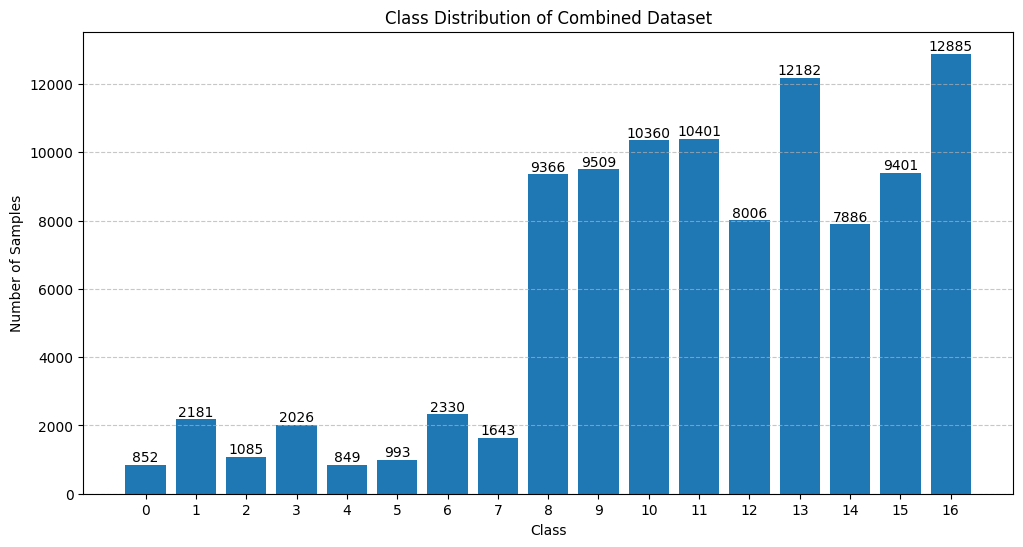

Number of samples in train dataset: 101955
Number of labels in train dataset: 17
Number of samples in test dataset: 10601
Number of labels in test dataset: 17


100%|█████████████████████████████████████████| 797/797 [01:27<00:00,  9.11it/s]


==> Evaluating ...
train Accuracy: 0.9947

Classification Report for train:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       852
           1       1.00      1.00      1.00      2181
           2       0.99      0.99      0.99      1085
           3       1.00      0.90      0.94      2026
           4       1.00      0.93      0.96       849
           5       0.88      1.00      0.93       993
           6       1.00      1.00      1.00      2330
           7       1.00      1.00      1.00      1643
           8       1.00      1.00      1.00      9366
           9       1.00      1.00      1.00      9509
          10       1.00      0.99      1.00     10360
          11       1.00      1.00      1.00     10401
          12       1.00      1.00      1.00      8006
          13       1.00      0.99      1.00     12182
          14       1.00      1.00      1.00      7886
          15       0.99      1.00      0.99      9401
     

In [17]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Define the combine_datasets function
def combine_datasets(*datasets):
    combined_images = []
    combined_labels = []
    label_offset = 0

    for i, (images, labels) in enumerate(datasets):
        # If images are grayscale, convert them to RGB by repeating the channel
        if images.ndim == 3:
            images = np.expand_dims(images, axis=-1)
            images = np.repeat(images, 3, axis=-1)
        combined_images.append(images)
        
        # Adjust labels for uniqueness
        adjusted_labels = labels + label_offset
        combined_labels.append(adjusted_labels)
        
        # Update label offset for the next dataset
        label_offset += len(np.unique(labels))
        
        # Print information about this dataset
        print(f'Dataset {i+1} labels:', np.unique(adjusted_labels))
        print(f'Dataset {i+1} shape:', images.shape)

    # Combine all images and labels
    combined_images = np.concatenate(combined_images, axis=0)
    combined_labels = np.concatenate(combined_labels, axis=0)

    print('\nCombined dataset:')
    print('Labels:', np.unique(combined_labels))
    print('Shape:', combined_images.shape)

    return combined_images, combined_labels

# Load your datasets
bloodmnist = np.load('/Users/srirammandalika/Downloads/MedMNIST/bloodmnist.npz')
pathmnist = np.load('/Users/srirammandalika/Downloads/MedMNIST/pathmnist.npz')

# Extract images and labels
bloodmnist_data = (bloodmnist['train_images'], bloodmnist['train_labels'])
pathmnist_data = (pathmnist['train_images'], pathmnist['train_labels'])

# Combine datasets
combined_images, combined_labels = combine_datasets(bloodmnist_data, pathmnist_data)

# Combine test datasets
test_combined_images, test_combined_labels = combine_datasets((bloodmnist['test_images'], bloodmnist['test_labels']), (pathmnist['test_images'], pathmnist['test_labels']))

def plot_class_distribution(labels, title="Class Distribution"):
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(unique_labels, counts)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')
    
    plt.xticks(unique_labels)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_class_distribution(combined_labels.flatten(), "Class Distribution of Combined Dataset")

class MedMNIST(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = MedMNIST(combined_images, combined_labels, transform=data_transform)
print('Number of samples in train dataset:', len(train_dataset))
print('Number of labels in train dataset:', len(np.unique(combined_labels)))

test_dataset = MedMNIST(test_combined_images, test_combined_labels, transform=data_transform)
print('Number of samples in test dataset:', len(test_dataset))
print('Number of labels in test dataset:', len(np.unique(test_combined_labels)))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define a simple CNN model
n_channels = 3
n_classes = len(np.unique(combined_labels))  
task = "multi-class"
lr = 0.01

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Train the model
NUM_EPOCHS = 45
BATCH_SIZE = 64

for epoch in range(NUM_EPOCHS):
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

def test(split):
    model.eval()
    y_true = []
    y_pred = []
    
    correct = 0
    total = 0

    if split == 'train':
        data_loader = train_loader_at_eval
    elif split == 'test':
        data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device)

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
                predicted = (outputs > 0.5).float()
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                _, predicted = torch.max(outputs.data, 1)

            total += targets.size(0)
            if task == 'multi-label, binary-class':
                correct += (predicted == targets).all(dim=1).sum().item()
            else:
                correct += (predicted == targets).sum().item()

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = correct / total
    print(f'{split} Accuracy: {accuracy:.4f}')

    if task == 'multi-label, binary-class':
        report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(y_true.shape[1])])
    else:
        report = classification_report(y_true, y_pred)
    
    print(f'\nClassification Report for {split}:')
    print(report)

print('==> Evaluating ...')
test('train')
test('test')

def test_with_ranges(split, label_ranges):
    model.eval()
    y_true = []
    y_pred = []
    
    correct = 0
    total = 0

    if split == 'train':
        data_loader = train_loader_at_eval
    elif split == 'test':
        data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device)

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
                predicted = (outputs > 0.5).float()
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                _, predicted = torch.max(outputs.data, 1)

            total += targets.size(0)
            if task == 'multi-label, binary-class':
                correct += (predicted == targets).all(dim=1).sum().item()
            else:
                correct += (predicted == targets).sum().item()

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = correct / total
    print(f'{split} Overall Accuracy: {accuracy:.4f}')

    print(f'\nAccuracy by label ranges for {split}:')
    
    for start, end in label_ranges:
        mask = (y_true >= start) & (y_true < end)
        if np.sum(mask) > 0:
            range_accuracy = accuracy_score(y_true[mask], y_pred[mask])
            print(f'Labels {start}-{end-1}: {range_accuracy:.4f}')

custom_ranges = [
    (0, 5),
    (6, 13),
]

print('==> Evaluating with ranges...')
test_with_ranges('train', custom_ranges)
test_with_ranges('test', custom_ranges)


In [ ]:
#With BloodMNIST and PathMNIST (Auxiliary)

In [ ]:
#Rotation Prediction

In [19]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Define the combine_datasets function
def combine_datasets(*datasets):
    combined_images = []
    combined_labels = []
    label_offset = 0

    for i, (images, labels) in enumerate(datasets):
        # If images are grayscale, convert them to RGB by repeating the channel
        if images.ndim == 3:
            images = np.expand_dims(images, axis=-1)
            images = np.repeat(images, 3, axis=-1)
        combined_images.append(images)
        
        # Adjust labels for uniqueness
        adjusted_labels = labels + label_offset
        combined_labels.append(adjusted_labels)
        
        # Update label offset for the next dataset
        label_offset += len(np.unique(labels))
        
        # Print information about this dataset
        print(f'Dataset {i+1} labels:', np.unique(adjusted_labels))
        print(f'Dataset {i+1} shape:', images.shape)

    # Combine all images and labels
    combined_images = np.concatenate(combined_images, axis=0)
    combined_labels = np.concatenate(combined_labels, axis=0)

    print('\nCombined dataset:')
    print('Labels:', np.unique(combined_labels))
    print('Shape:', combined_images.shape)

    return combined_images, combined_labels

# Load your datasets
bloodmnist = np.load('/Users/srirammandalika/Downloads/MedMNIST/bloodmnist.npz')
pathmnist = np.load('/Users/srirammandalika/Downloads/MedMNIST/pathmnist.npz')

# Extract images and labels
bloodmnist_data = (bloodmnist['train_images'], bloodmnist['train_labels'])
pathmnist_data = (pathmnist['train_images'], pathmnist['train_labels'])

# Combine datasets
combined_images, combined_labels = combine_datasets(bloodmnist_data, pathmnist_data)

# Split dataset
total_samples = len(combined_labels)
pretext_size = int(0.2 * total_samples)
val_size = int(0.1 * total_samples)
test_size = int(0.1 * total_samples)
main_task_size = total_samples - pretext_size - val_size - test_size

# Create the datasets for pretext task and main task
dataset = list(zip(combined_images, combined_labels))
pretext_dataset, remaining_dataset = random_split(dataset, [pretext_size, total_samples - pretext_size])
main_task_dataset, test_dataset, val_dataset = random_split(remaining_dataset, [main_task_size, test_size, val_size])

# Define custom dataset class for rotation prediction
class RotationPredictionDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image, _ = self.images[idx]
        label = np.random.choice([0, 1, 2, 3])
        rotated_image = np.rot90(image, k=label).copy()
        
        if self.transform:
            rotated_image = self.transform(rotated_image)

        return rotated_image, label

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

pretext_train_dataset = RotationPredictionDataset(pretext_dataset, transform=data_transform)
val_dataset = RotationPredictionDataset(val_dataset, transform=data_transform)
test_dataset = RotationPredictionDataset(test_dataset, transform=data_transform)

pretext_train_loader = DataLoader(pretext_train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define a simple CNN model for rotation prediction
class RotationNet(nn.Module):
    def __init__(self, in_channels):
        super(RotationNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Train the model for rotation prediction
model = RotationNet(in_channels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

NUM_EPOCHS = 45

for epoch in range(NUM_EPOCHS):
    model.train()
    for inputs, targets in tqdm(pretext_train_loader):
        inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

def evaluate(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []
    
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')

    report = classification_report(y_true, y_pred, target_names=['0', '90', '180', '270'])
    print(f'\nClassification Report:')
    print(report)

print('==> Evaluating on validation set...')
evaluate(model, val_loader)

print('==> Evaluating on test set...')
evaluate(model, test_loader)


Dataset 1 labels: [0 1 2 3 4 5 6 7]
Dataset 1 shape: (11959, 28, 28, 3)
Dataset 2 labels: [ 8  9 10 11 12 13 14 15 16]
Dataset 2 shape: (89996, 28, 28, 3)

Combined dataset:
Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Shape: (101955, 28, 28, 3)


100%|█████████████████████████████████████████| 160/160 [00:15<00:00, 10.30it/s]


==> Evaluating on validation set...
Accuracy: 0.7032

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.59      0.71      2464
          90       0.54      0.90      0.68      2582
         180       0.85      0.60      0.70      2628
         270       0.75      0.72      0.74      2521

    accuracy                           0.70     10195
   macro avg       0.76      0.70      0.71     10195
weighted avg       0.76      0.70      0.71     10195

==> Evaluating on test set...
Accuracy: 0.7053

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.61      0.73      2535
          90       0.53      0.92      0.68      2522
         180       0.85      0.58      0.69      2566
         270       0.77      0.72      0.74      2572

    accuracy                           0.71     10195
   macro avg       0.76      0.71      0.71     10195
weighted avg       0.76      0.71    

==> Plotting sampled predictions...


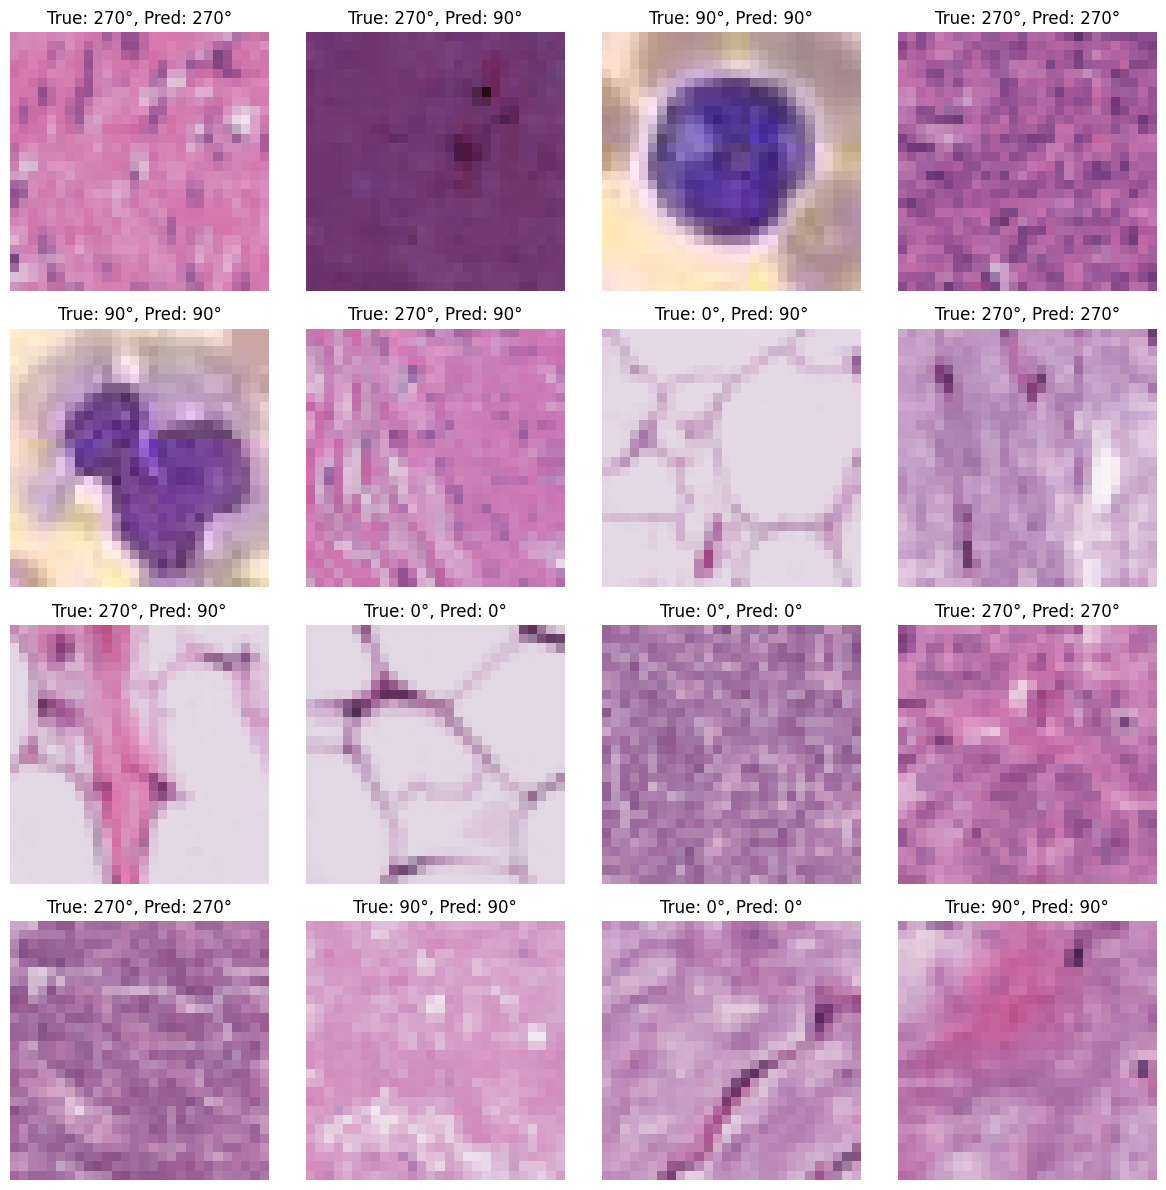

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot sampled images with their predicted classes
def plot_sample_predictions(model, data_loader, num_samples=16):
    model.eval()
    samples = []
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            samples.extend(inputs.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

            if len(samples) >= num_samples:
                break

    samples = samples[:num_samples]
    predictions = predictions[:num_samples]
    true_labels = true_labels[:num_samples]

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        img = samples[i].transpose(1, 2, 0)
        img = (img * 0.5) + 0.5  # Unnormalize
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f"True: {true_labels[i] * 90}°, Pred: {predictions[i] * 90}°")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Plotting sampled predictions
print('==> Plotting sampled predictions...')
plot_sample_predictions(model, test_loader, num_samples=16)


In [ ]:
# Super Resolution:

#Implementation: Downscale an image to a lower resolution and train the model to upscale it back to the original resolution.

Dataset 1 labels: [0 1 2 3 4 5 6 7]
Dataset 1 shape: (11959, 28, 28, 3)
Dataset 2 labels: [ 8  9 10 11 12 13 14 15 16]
Dataset 2 shape: (89996, 28, 28, 3)

Combined dataset:
Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Shape: (101955, 28, 28, 3)


100%|█████████████████████████████████████████| 160/160 [00:58<00:00,  2.72it/s]


==> Evaluating on test set...


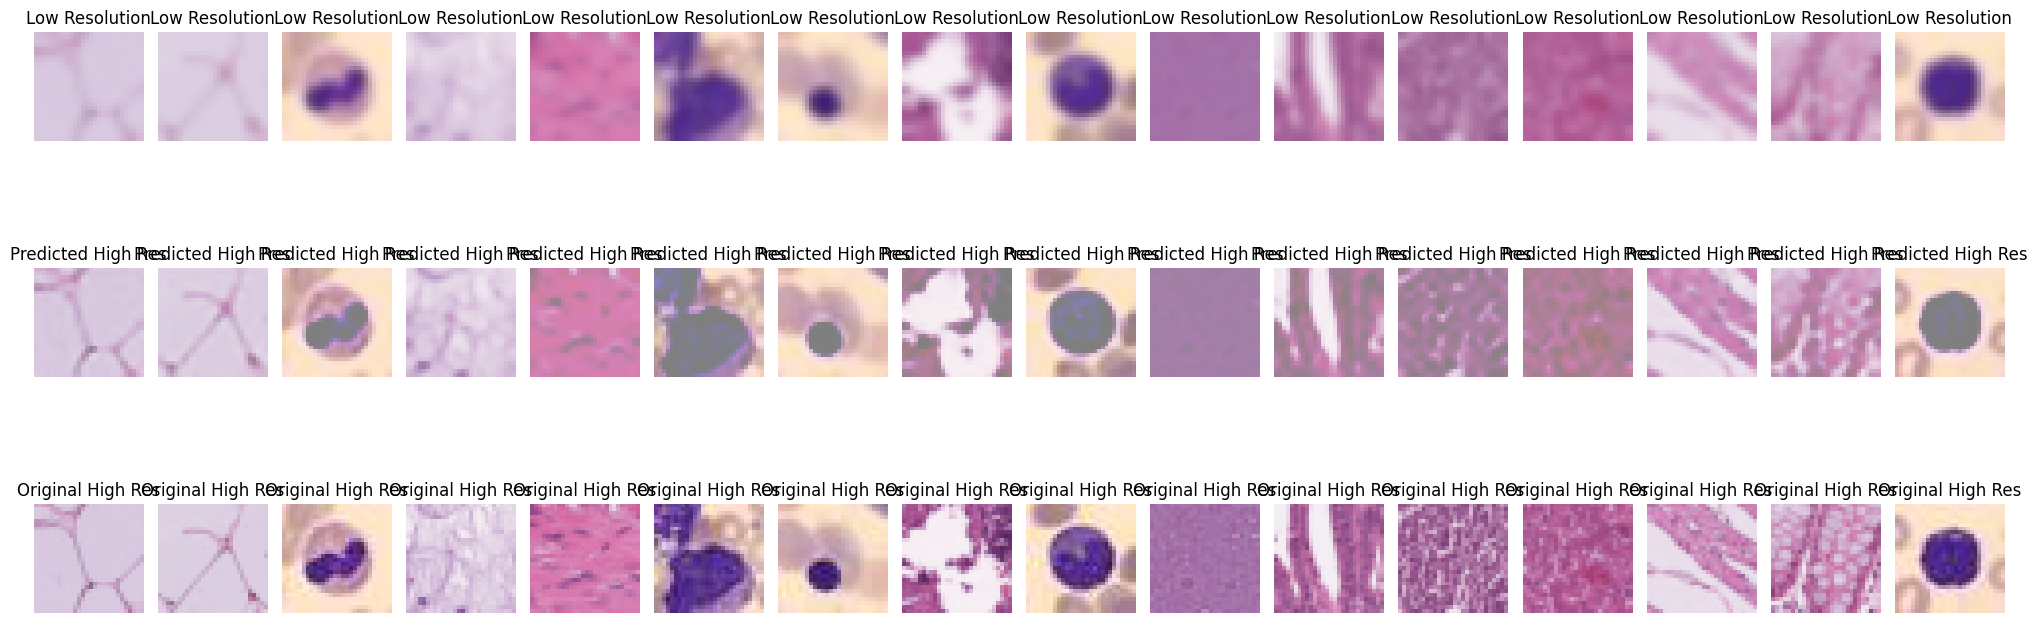

In [20]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the combine_datasets function
def combine_datasets(*datasets):
    combined_images = []
    combined_labels = []
    label_offset = 0

    for i, (images, labels) in enumerate(datasets):
        # If images are grayscale, convert them to RGB by repeating the channel
        if images.ndim == 3:
            images = np.expand_dims(images, axis=-1)
            images = np.repeat(images, 3, axis=-1)
        combined_images.append(images)
        
        # Adjust labels for uniqueness
        adjusted_labels = labels + label_offset
        combined_labels.append(adjusted_labels)
        
        # Update label offset for the next dataset
        label_offset += len(np.unique(labels))
        
        # Print information about this dataset
        print(f'Dataset {i+1} labels:', np.unique(adjusted_labels))
        print(f'Dataset {i+1} shape:', images.shape)

    # Combine all images and labels
    combined_images = np.concatenate(combined_images, axis=0)
    combined_labels = np.concatenate(combined_labels, axis=0)

    print('\nCombined dataset:')
    print('Labels:', np.unique(combined_labels))
    print('Shape:', combined_images.shape)

    return combined_images, combined_labels

# Load your datasets
bloodmnist = np.load('/Users/srirammandalika/Downloads/MedMNIST/bloodmnist.npz')
pathmnist = np.load('/Users/srirammandalika/Downloads/MedMNIST/pathmnist.npz')

# Extract images and labels
bloodmnist_data = (bloodmnist['train_images'], bloodmnist['train_labels'])
pathmnist_data = (pathmnist['train_images'], pathmnist['train_labels'])

# Combine datasets
combined_images, combined_labels = combine_datasets(bloodmnist_data, pathmnist_data)

# Split dataset
total_samples = len(combined_labels)
pretext_size = int(0.2 * total_samples)
val_size = int(0.1 * total_samples)
test_size = int(0.1 * total_samples)
main_task_size = total_samples - pretext_size - val_size - test_size

# Create the datasets for pretext task and main task
dataset = list(zip(combined_images, combined_labels))
pretext_dataset, remaining_dataset = random_split(dataset, [pretext_size, total_samples - pretext_size])
main_task_dataset, test_dataset, val_dataset = random_split(remaining_dataset, [main_task_size, test_size, val_size])

# Define custom dataset class for super-resolution
class SuperResolutionDataset(Dataset):
    def __init__(self, images, scale_factor=2, transform=None):
        self.images = images
        self.scale_factor = scale_factor
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image, _ = self.images[idx]
        low_res_image = transforms.functional.resize(transforms.functional.to_pil_image(image), [image.shape[0] // self.scale_factor, image.shape[1] // self.scale_factor])
        low_res_image = transforms.functional.resize(low_res_image, [image.shape[0], image.shape[1]])

        if self.transform:
            image = self.transform(image)
            low_res_image = self.transform(low_res_image)

        return low_res_image, image

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

pretext_train_dataset = SuperResolutionDataset(pretext_dataset, transform=data_transform)
val_dataset = SuperResolutionDataset(val_dataset, transform=data_transform)
test_dataset = SuperResolutionDataset(test_dataset, transform=data_transform)

pretext_train_loader = DataLoader(pretext_train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define a simple CNN model for super-resolution
class SuperResolutionNet(nn.Module):
    def __init__(self, in_channels):
        super(SuperResolutionNet, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Train the model for super-resolution
model = SuperResolutionNet(in_channels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 45

for epoch in range(NUM_EPOCHS):
    model.train()
    for inputs, targets in tqdm(pretext_train_loader):
        inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

def evaluate(model, data_loader, num_samples=16):
    model.eval()
    samples = []
    predictions = []
    original_images = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(inputs)

            samples.extend(inputs.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())
            original_images.extend(targets.cpu().numpy())

            if len(samples) >= num_samples:
                break

    samples = samples[:num_samples]
    predictions = predictions[:num_samples]
    original_images = original_images[:num_samples]

    fig, axes = plt.subplots(3, num_samples, figsize=(20, 8))
    for i in range(num_samples):
        # Plot the low resolution image
        ax = axes[0, i]
        low_res_img = samples[i].transpose(1, 2, 0)
        low_res_img = (low_res_img * 0.5) + 0.5  # Unnormalize
        low_res_img = np.clip(low_res_img, 0, 1)
        ax.imshow(low_res_img)
        ax.set_title("Low Resolution")
        ax.axis('off')

        # Plot the predicted high resolution image
        ax = axes[1, i]
        pred_img = predictions[i].transpose(1, 2, 0)
        pred_img = (pred_img * 0.5) + 0.5  # Unnormalize
        pred_img = np.clip(pred_img, 0, 1)
        ax.imshow(pred_img)
        ax.set_title("Predicted High Res")
        ax.axis('off')

        # Plot the original high resolution image
        ax = axes[2, i]
        orig_img = original_images[i].transpose(1, 2, 0)
        orig_img = (orig_img * 0.5) + 0.5  # Unnormalize
        orig_img = np.clip(orig_img, 0, 1)
        ax.imshow(orig_img)
        ax.set_title("Original High Res")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print('==> Evaluating on test set...')
evaluate(model, test_loader, num_samples=16)


==> Evaluating on test set...


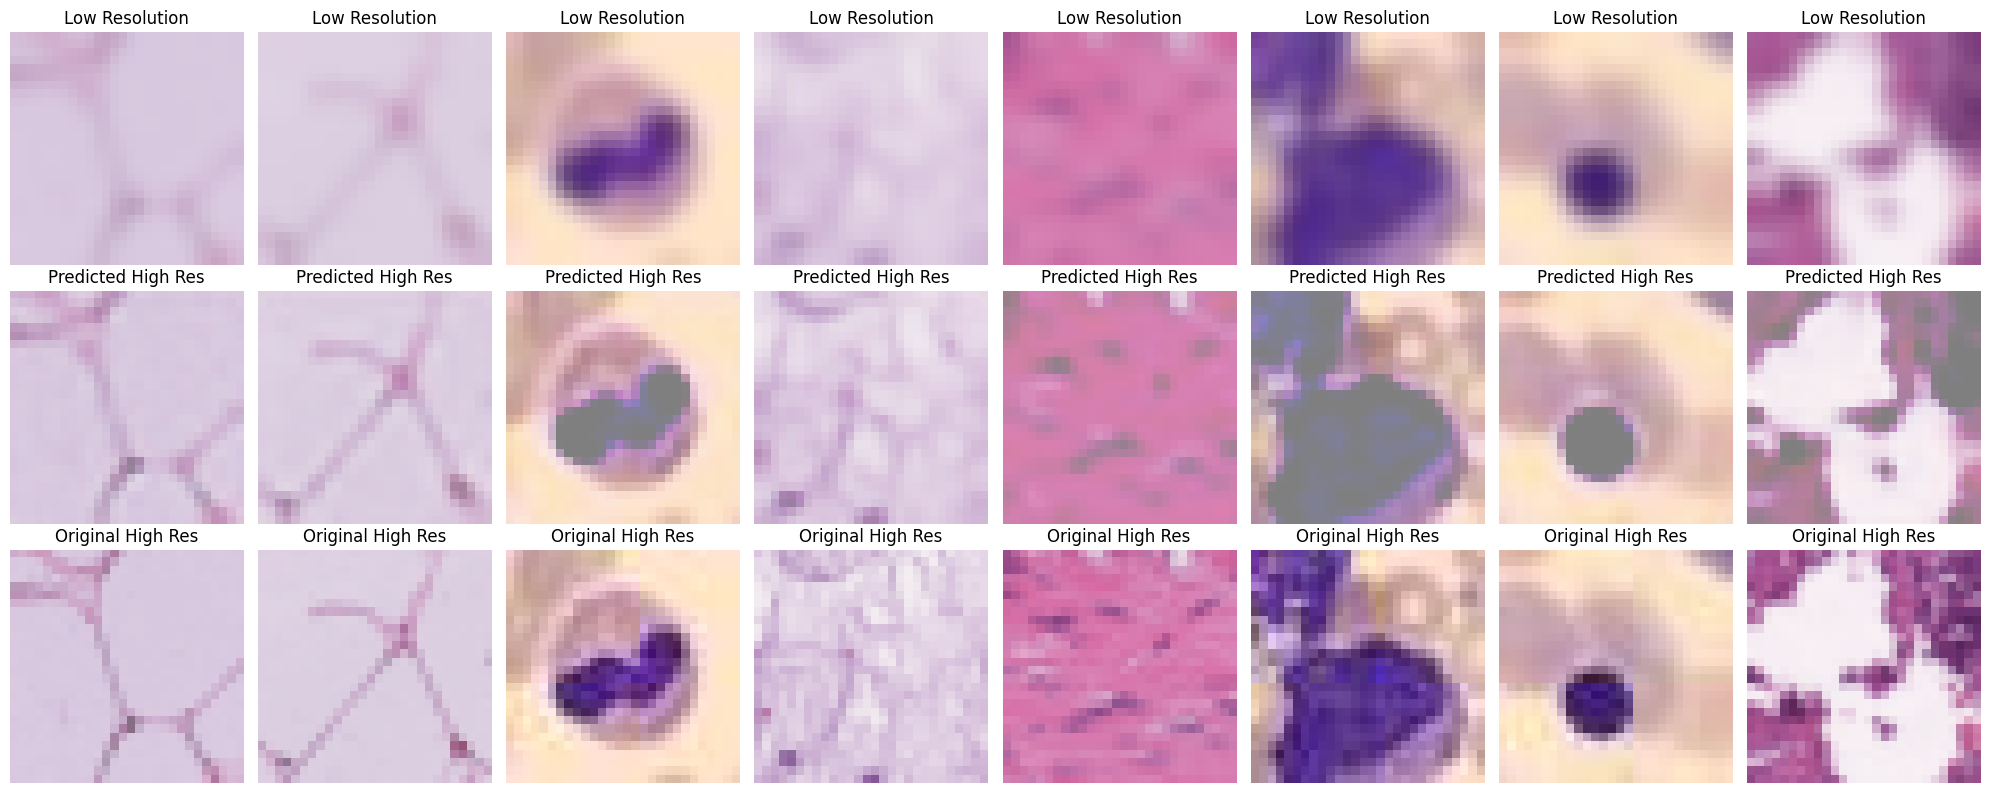

In [21]:
print('==> Evaluating on test set...')
evaluate(model, test_loader, num_samples=8)


In [ ]:
# Jigsaw Puzzle Solver

In [ ]:
# It's not running, due to kernel failure. Kindly give it a run if you have a powerful GPU. Thanks!

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
import itertools

# Define the combine_datasets function
def combine_datasets(*datasets):
    combined_images = []
    combined_labels = []
    label_offset = 0

    for i, (images, labels) in enumerate(datasets):
        # If images are grayscale, convert them to RGB by repeating the channel
        if images.ndim == 3:
            images = np.expand_dims(images, axis=-1)
            images = np.repeat(images, 3, axis=-1)
        combined_images.append(images)
        
        # Adjust labels for uniqueness
        adjusted_labels = labels + label_offset
        combined_labels.append(adjusted_labels)
        
        # Update label offset for the next dataset
        label_offset += len(np.unique(labels))
        
        # Print information about this dataset
        print(f'Dataset {i+1} labels:', np.unique(adjusted_labels))
        print(f'Dataset {i+1} shape:', images.shape)

    # Combine all images and labels
    combined_images = np.concatenate(combined_images, axis=0)
    combined_labels = np.concatenate(combined_labels, axis=0)

    print('\nCombined dataset:')
    print('Labels:', np.unique(combined_labels))
    print('Shape:', combined_images.shape)

    return combined_images, combined_labels

# Load your datasets
bloodmnist = np.load('/Users/srirammandalika/Downloads/MedMNIST/bloodmnist.npz')
pathmnist = np.load('/Users/srirammandalika/Downloads/MedMNIST/pathmnist.npz')

# Extract images and labels
bloodmnist_data = (bloodmnist['train_images'], bloodmnist['train_labels'])
pathmnist_data = (pathmnist['train_images'], pathmnist['train_labels'])

# Combine datasets
combined_images, combined_labels = combine_datasets(bloodmnist_data, pathmnist_data)

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Split dataset
total_samples = len(combined_labels)
pretext_size = int(0.2 * total_samples)
val_size = int(0.1 * total_samples)
test_size = int(0.1 * total_samples)
main_task_size = total_samples - pretext_size - val_size - test_size

# Create the datasets for pretext task and main task
dataset = list(zip(combined_images, combined_labels))
pretext_dataset, remaining_dataset = random_split(dataset, [pretext_size, total_samples - pretext_size])
main_task_dataset, test_dataset, val_dataset = random_split(remaining_dataset, [main_task_size, test_size, val_size])

# Define custom dataset class for jigsaw puzzle solving
class JigsawPuzzleDataset(Dataset):
    def __init__(self, images, transform=None, patch_size=7):
        self.images = images
        self.transform = transform
        self.patch_size = patch_size
        self.permutations = np.array(list(itertools.permutations(range((28 // patch_size)**2))))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image, _ = self.images[idx]
        patches = []
        for i in range(0, 28, self.patch_size):
            for j in range(0, 28, self.patch_size):
                patch = image[i:i + self.patch_size, j:j + self.patch_size]
                patches.append(patch)
        patches = np.array(patches)
        perm_idx = np.random.choice(len(self.permutations))
        perm = self.permutations[perm_idx]
        shuffled_patches = patches[perm]
        shuffled_image = shuffled_patches.reshape(28, 28, 3)
        
        if self.transform:
            shuffled_image = self.transform(shuffled_image)
            patches = [self.transform(p) for p in patches]

        return shuffled_image, torch.tensor(perm_idx)

# Create the JigsawPuzzleDataset for pretext task
pretext_train_dataset = JigsawPuzzleDataset(pretext_dataset, transform=data_transform)
val_dataset = JigsawPuzzleDataset(val_dataset, transform=data_transform)
test_dataset = JigsawPuzzleDataset(test_dataset, transform=data_transform)

pretext_train_loader = DataLoader(pretext_train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Define a simple CNN model for jigsaw puzzle solving
class JigsawNet(nn.Module):
    def __init__(self, in_channels, num_permutations):
        super(JigsawNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(256 * (28 // 8) * (28 // 8), 512),
            nn.ReLU(),
            nn.Linear(512, num_permutations)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Train the model for jigsaw puzzle solving
num_permutations = len(pretext_train_dataset.permutations)
model = JigsawNet(in_channels=3, num_permutations=num_permutations)
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 45

for epoch in range(NUM_EPOCHS):
    model.train()
    for inputs, targets in tqdm(pretext_train_loader):
        inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

def evaluate_jigsaw(model, data_loader, num_samples=8):
    model.eval()
    samples = []
    predictions = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            samples.extend(inputs.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

            if len(samples) >= num_samples:
                break

    samples = samples[:num_samples]
    predictions = predictions[:num_samples]

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        img = samples[i].transpose(1, 2, 0)
        img = (img * 0.5) + 0.5  # Unnormalize
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f"Predicted: {predictions[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print('==> Evaluating on test set...')
evaluate_jigsaw(model, test_loader, num_samples=16)


In [ ]:
# Image Completion

Dataset 1 labels: [0 1 2 3 4 5 6 7]
Dataset 1 shape: (11959, 28, 28, 3)
Dataset 2 labels: [ 8  9 10 11 12 13 14 15 16]
Dataset 2 shape: (89996, 28, 28, 3)

Combined dataset:
Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Shape: (101955, 28, 28, 3)


  0%|                                                   | 0/160 [00:00<?, ?it/s]/Users/srirammandalika/anaconda3/envs/New0/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|█████████████████████████████████████████| 160/160 [00:34<00:00,  4.65it/s]


==> Evaluating on test set...


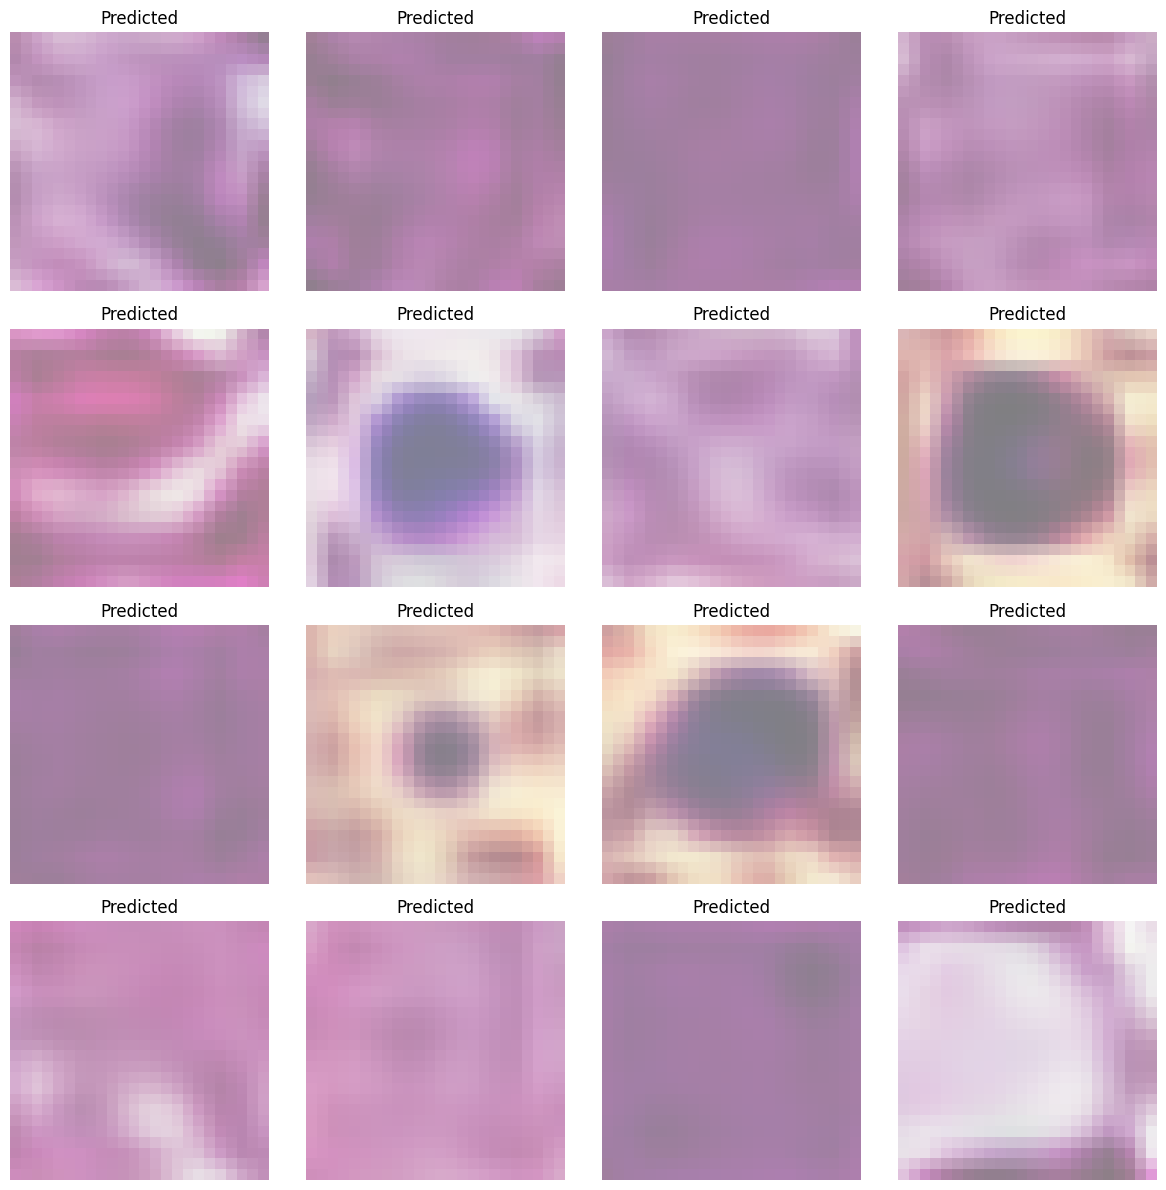

In [11]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
import itertools

# Define the combine_datasets function
def combine_datasets(*datasets):
    combined_images = []
    combined_labels = []
    label_offset = 0

    for i, (images, labels) in enumerate(datasets):
        # If images are grayscale, convert them to RGB by repeating the channel
        if images.ndim == 3:
            images = np.expand_dims(images, axis=-1)
            images = np.repeat(images, 3, axis=-1)
        combined_images.append(images)
        
        # Adjust labels for uniqueness
        adjusted_labels = labels + label_offset
        combined_labels.append(adjusted_labels)
        
        # Update label offset for the next dataset
        label_offset += len(np.unique(labels))
        
        # Print information about this dataset
        print(f'Dataset {i+1} labels:', np.unique(adjusted_labels))
        print(f'Dataset {i+1} shape:', images.shape)

    # Combine all images and labels
    combined_images = np.concatenate(combined_images, axis=0)
    combined_labels = np.concatenate(combined_labels, axis=0)

    print('\nCombined dataset:')
    print('Labels:', np.unique(combined_labels))
    print('Shape:', combined_images.shape)

    return combined_images, combined_labels

# Load your datasets
bloodmnist = np.load('/Users/srirammandalika/Downloads/MedMNIST/bloodmnist.npz')
pathmnist = np.load('/Users/srirammandalika/Downloads/MedMNIST/pathmnist.npz')

# Extract images and labels
bloodmnist_data = (bloodmnist['train_images'], bloodmnist['train_labels'])
pathmnist_data = (pathmnist['train_images'], pathmnist['train_labels'])

# Combine datasets
combined_images, combined_labels = combine_datasets(bloodmnist_data, pathmnist_data)

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Split dataset
total_samples = len(combined_labels)
pretext_size = int(0.2 * total_samples)
val_size = int(0.1 * total_samples)
test_size = int(0.1 * total_samples)
main_task_size = total_samples - pretext_size - val_size - test_size

# Create the datasets for pretext task and main task
dataset = list(zip(combined_images, combined_labels))
pretext_dataset, remaining_dataset = random_split(dataset, [pretext_size, total_samples - pretext_size])
main_task_dataset, test_dataset, val_dataset = random_split(remaining_dataset, [main_task_size, test_size, val_size])

# Define custom dataset class for inpainting
class InpaintingDataset(Dataset):
    def __init__(self, images, transform=None, mask_size=7):
        self.images = images
        self.transform = transform
        self.mask_size = mask_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image, _ = self.images[idx]
        mask = np.ones_like(image)
        i, j = np.random.randint(0, 28 - self.mask_size, 2)
        mask[i:i + self.mask_size, j:j + self.mask_size] = 0
        
        masked_image = image * mask
        
        if self.transform:
            masked_image = self.transform(masked_image)
            image = self.transform(image)

        return masked_image, image

# Create the InpaintingDataset for pretext task
pretext_train_dataset = InpaintingDataset(pretext_dataset, transform=data_transform)
val_dataset = InpaintingDataset(val_dataset, transform=data_transform)
test_dataset = InpaintingDataset(test_dataset, transform=data_transform)

pretext_train_loader = DataLoader(pretext_train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define a simple CNN model for inpainting
class InpaintingNet(nn.Module):
    def __init__(self, in_channels):
        super(InpaintingNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Train the model for inpainting
model = InpaintingNet(in_channels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 45

for epoch in range(NUM_EPOCHS):
    model.train()
    for inputs, targets in tqdm(pretext_train_loader):
        inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = transforms.Resize(outputs.size()[2:])(targets)  # Resize targets to match the outputs
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

def evaluate_inpainting(model, data_loader, num_samples=16):
    model.eval()
    samples = []
    predictions = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(inputs)

            samples.extend(inputs.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())

            if len(samples) >= num_samples:
                break

    samples = samples[:num_samples]
    predictions = predictions[:num_samples]

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        img = predictions[i].transpose(1, 2, 0)
        img = (img * 0.5) + 0.5  # Unnormalize
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f"Predicted")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print('==> Evaluating on test set...')
evaluate_inpainting(model, test_loader, num_samples=16)


==> Evaluating on test set...


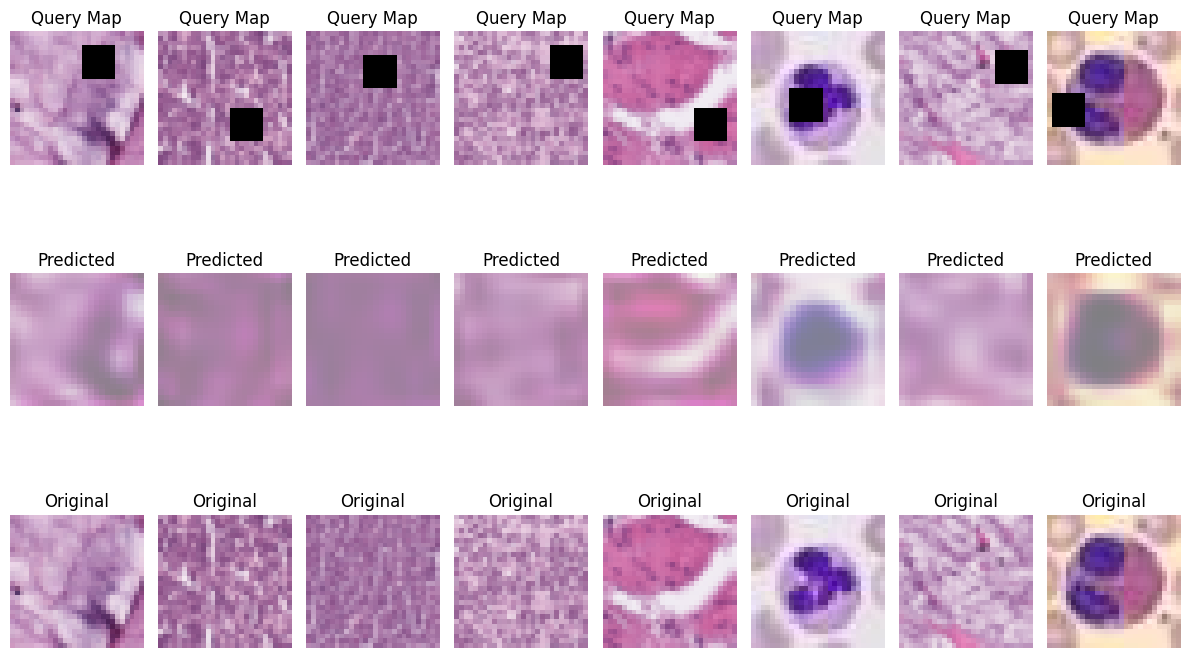

In [15]:
def evaluate_inpainting(model, data_loader, num_samples=16):
    model.eval()
    samples = []
    predictions = []
    original_images = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(inputs)

            samples.extend(inputs.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())
            original_images.extend(targets.cpu().numpy())

            if len(samples) >= num_samples:
                break

    samples = samples[:num_samples]
    predictions = predictions[:num_samples]
    original_images = original_images[:num_samples]

    fig, axes = plt.subplots(3, num_samples, figsize=(12, 8))
    for i in range(num_samples):
        # Plot the masked image
        ax = axes[0, i]
        img = samples[i].transpose(1, 2, 0)
        img = (img * 0.5) + 0.5  # Unnormalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title("Query Map")
        ax.axis('off')

        # Plot the predicted image
        ax = axes[1, i]
        img = predictions[i].transpose(1, 2, 0)
        img = (img * 0.5) + 0.5  # Unnormalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title("Predicted")
        ax.axis('off')

        # Plot the original image
        ax = axes[2, i]
        img = original_images[i].transpose(1, 2, 0)
        img = (img * 0.5) + 0.5  # Unnormalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title("Original")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print('==> Evaluating on test set...')
evaluate_inpainting(model, test_loader, num_samples=8)
